In [1]:
import numpy as np
import pandas as pd # for loading data
import re # for removing special characters
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords # For removing stopwords

[nltk_data] Downloading package wordnet to /Users/Robin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("dataset.csv")
df = df.drop(['Singer', 'Date', 'Tags'], axis=1)

In [3]:
def get_index(word, word_list):
    for index, value in enumerate(word_list):
        if word == value:
            return index

## Creating a word list of all possible words from all Song Lyrics

In [4]:
corpus = []
lyrics = df['Lyrics']
sw = stopwords.words("english")
word_list = []
for i, value in df.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', str(lyrics[i])) # removes special characters
    text = text.lower() # lowercases everything
    text = text.split() # splits words
    text = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in text if not word in set(sw)]
    formatted_text = ""
    for word in text:
        if word not in word_list:
            word_list.append(word)
        formatted_text+=word+" "
    corpus.append(formatted_text)
    df['Lyrics'][i] = formatted_text
lyrics = corpus

#Cleaning variables to save some memory
del corpus, sw, text

### Function that creates a one-hot vector for the given text from the word_list

In [5]:
from tensorflow.keras.utils import to_categorical

def one_hot(text, word_list):
    word_vector = np.zeros(shape=(1,len(word_list)))
    text = text.split() # splits words
    for w in text:
        word_vector[0, get_index(w, word_list)] = 1
    return word_vector[0]


## Creating one-hot vector for genres

In [6]:
from tensorflow.keras.utils import to_categorical
genres = []

for i, value in df.iterrows():
    genre = df['Genre'][i]
    index = 0
    if genre == '[\'Pop\']': index = 0
    elif genre == '[\'Rock\']': index = 1
    elif genre == '[\'Hip-Hop/Rap\']': index = 2
    elif genre == '[\'Country\']': index = 3
    elif genre == '[\'R&B/Soul\']': index = 4
    elif genre == '[\'Metal\']': index = 5
    elif genre == '[\'Alternative/Indie\']': index = 6
    elif genre == '[\'Folk\']': index = 7
    genres.append(index)

genres = to_categorical(genres, 8)

## Replace all the lyrics with their respctive vector of word occurrences to be used as the input layer for the neural network

In [7]:
all_lyrics = np.zeros(shape=(len(df),len(word_list)))
for index, value in df.iterrows():
    all_lyrics[index] = one_hot(str(df['Lyrics'][index]), word_list)
print(all_lyrics.shape)

#Cleaning variables to save some memory
del df

(14400, 40677)


## **Don't rerun the cell below, as this will result in new test/train sets. Can rerun all other cells except this one. Probably also don't want to rerun all cells above since they always do the exact same thing**

In [8]:
from sklearn.model_selection import train_test_split

lyrics_train, lyrics_test, genre_train, genre_test = train_test_split(all_lyrics, genres, train_size = 0.85, test_size = 0.15, shuffle=True) 

#Cleaning Lists, since they take up almost 5GB
del all_lyrics, genres

# Neural Network stuff 
## **Modify and run only the cells below to change the neural network**

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(128, input_shape=(len(word_list),))) # first dense layer, 32 hidden units
model.add(Activation('relu'))            # activation layer
model.add(Dense(20)) 
model.add(Dense(8))                     # second dense layer
model.add(Activation('softmax'))         # output class probabilities

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5206784   
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 168       
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
Total params: 5,209,532
Trainable params: 5,209,532
Non-trainable params: 0
_________________________________________________________________


In [125]:
from tensorflow.keras.optimizers import SGD, Adam

optimizer = Adam(lr=0.001) # lr is the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
model.fit(lyrics_train, genre_train, epochs=10, validation_split=1/10);

Train on 11016 samples, validate on 1224 samples
Epoch 1/10
11016/11016 [==============================] - 17s 2ms/sample - loss: 1.4223 - accuracy: 0.4778 - val_loss: 1.2761 - val_accuracy: 0.5458
Epoch 2/10
11016/11016 [==============================] - 14s 1ms/sample - loss: 0.6432 - accuracy: 0.7891 - val_loss: 1.3636 - val_accuracy: 0.5482
Epoch 3/10
11016/11016 [==============================] - 13s 1ms/sample - loss: 0.2990 - accuracy: 0.9112 - val_loss: 1.6059 - val_accuracy: 0.5335
Epoch 4/10
11016/11016 [==============================] - 13s 1ms/sample - loss: 0.1544 - accuracy: 0.9625 - val_loss: 1.9687 - val_accuracy: 0.5131
Epoch 5/10
11016/11016 [==============================] - 14s 1ms/sample - loss: 0.0879 - accuracy: 0.9837 - val_loss: 2.1201 - val_accuracy: 0.5212
Epoch 6/10
11016/11016 [==============================] - 14s 1ms/sample - loss: 0.0667 - accuracy: 0.9896 - val_loss: 2.2234 - val_accuracy: 0.5155
Epoch 7/10
11016/11016 [==============================] -

## Testing the Neural Network's performace + Confusion Matrix

In [127]:
results = model.evaluate(lyrics_test, genre_test, batch_size=128)

2160/2160 [==============================] - 2s 913us/sample - loss: 2.8956 - accuracy: 0.5046


In [128]:
def one_hot_reverse():
    
    genres = []
    genre_list = list(genre_test)

    for i in range(len(genre_list)):
        x = genre_list[i]
        for index in range(0, 8):
            #print(str(list(genre_test[index])))
            if x[index] == 1.0:
                #print(str(list(genre_test[index])))
                genres.append(index)

    return genres

In [129]:
from sklearn.metrics import confusion_matrix


y_pred=model.predict_classes(lyrics_test)
cm=confusion_matrix(one_hot_reverse(),y_pred)
print(cm)

[[ 81  32   7  15  57  16  15  41]
 [ 15  84   0  19  37  43  24  36]
 [  2   1 177   1  68   9   8   2]
 [  4  15   0 174  19   8   6  51]
 [ 10  18  13  20 191  11  10  11]
 [  4  31   3   6  12 171  16  24]
 [ 11  32   8  18  73  14  74  33]
 [  9  30   1  44  14  24  19 138]]


                   Pop  Rock  Hip-Hop/Rap  Country  R&B/Soul  Metal  \
Pop                 81    32            7       15        57     16   
Rock                15    84            0       19        37     43   
Hip-Hop/Rap          2     1          177        1        68      9   
Country              4    15            0      174        19      8   
R&B/Soul            10    18           13       20       191     11   
Metal                4    31            3        6        12    171   
Alternative/Indie   11    32            8       18        73     14   
Folk                 9    30            1       44        14     24   

                   Alternative/Indie  Folk  
Pop                               15    41  
Rock                              24    36  
Hip-Hop/Rap                        8     2  
Country                            6    51  
R&B/Soul                          10    11  
Metal                             16    24  
Alternative/Indie                 74    33  


(8.0, 0.0)

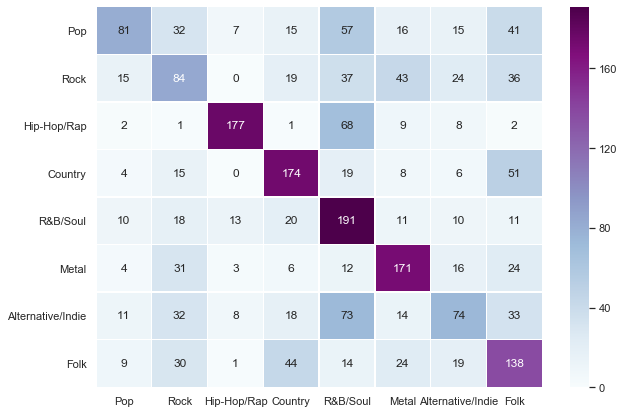

In [130]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

genre_list = ['Pop','Rock', 'Hip-Hop/Rap', 'Country', 'R&B/Soul', 'Metal', 'Alternative/Indie', 'Folk']

df_cm = pd.DataFrame(cm, index = genre_list, columns = genre_list)
print(df_cm)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidth=0.5, fmt='g', cmap="BuPu")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values